# CS 189 HW 6: Neural Networks
**Note:** before starting this notebook, please make a copy of it, otherwise your changes will not persist.

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on MNIST (Deliverable = training graphs)
3. Train a model on CIFAR-10 for Kaggle (Deliverable = kaggle submission and explanation of methods)

The last part of this notebook is left open for you to explore as many techniques as you want to do as well as possible on the dataset.

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

Note that like all other assignments, you are free to use this notebook or not. You just need to complete the deliverables and turn in your code. If you want to run everything outside of the notebook, make sure to appropriately install pytorch to download the datasets and copy out the code for kaggle submission. If you don't want to use pytorch and instead want to use Tensorflow, feel free, but you may still need to install pytorch to download the datasets.


In [2]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

They also support slicing and math operations very similar to numpy. See the examples below:

In [ ]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

## Autograd
This small section shows you how pytorch computes gradients. When we create tenors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [ ]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True) 
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update 
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [ ]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `foward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [ ]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

In [ ]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [ ]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [ ]:
import tqdm.notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))
        
# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cpu


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.7734763711690903


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.6815078720450402


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.6103248372673988


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.5555179014801979


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.5124296322464943


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.47810235917568206


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.4506960652768612


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.42806430980563165


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.40936721712350843


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.3933811642229557
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size([10]) torch.Size([10, 2])
torch.Size([10]) torch.Size(

# Task 1: MLP For FashionMNIST
Earlier in this course you trained SVMs and GDA models on MNIST. Now you will train a multi-layer perceptron model on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training an MLP on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training. 

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Some pytorch components you should definetily use:
1. `nn.Linear`
2. Some activation: `nn.ReLU`, `nn.Tanh`, `nn.Sigmoid`, etc.
3. `nn.CrossEntropyLoss`

Here are challenges you will need to overcome:
1. The data is default configured in image form ie (28 x 28), versus one feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or dense, and may not have convolutions etc., but you can use anything in torch.optim or any layers in torch.nn besides nn.Linear that do not have weights. 

In [ ]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11931951.16it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202277.24it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3754240.27it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19007286.08it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
### YOUR CODE HERE ###
import tqdm.notebook
import tensorflow
import torch.nn as nn
import torch.nn.functional as func

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

torch.manual_seed(10)

epochs = 8
batch_size = 10
learning_rate = 0.01

class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(28 * 28, 512)
    self.layer2 = nn.Linear(512, 512)
    self.layer3 = nn.Linear(512, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = func.relu(self.layer1(x))
    x = func.relu(self.layer2(x))
    x = (self.layer3(x))
    
    return (x)

model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
training_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=10, shuffle=True)

training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

model.train() # Put model in training mode
for epoch in range(epochs):
    print("Starting epoch", epoch + 1)

    training_losses = []
    for x, y in tqdm.notebook.tqdm(training_loader, unit="batch"):
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    
    training_loss.append(np.mean(training_losses))
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

    with torch.no_grad():
        model.eval() # Put model in eval mode
        num_correct = 0
        for x, y in training_loader:
            output = model(x)
            tmp, pred = torch.max(output, 1)
            num_correct += np.squeeze(pred.eq(y.data.view_as(pred)))

        training_acc.append(torch.sum(num_correct).item() / len(training_data))
        print("Finished Epoch", epoch + 1, ", training accuracy:", torch.sum(num_correct).item() / len(training_data))
        
        num_correct = 0
        valid_loss = 0.0
        for x, y in validation_loader:
            output = model(x)
            loss = loss_function(output, y)
            valid_loss += (loss.item() * x.size(0))
            tmp, pred = torch.max(output, 1)
            num_correct += np.squeeze(pred.eq(y.data.view_as(pred)))

        validation_loss.append(valid_loss / len(validation_data))
        validation_acc.append(torch.sum(num_correct).item() / len(validation_data))
        print("Finished Epoch", epoch + 1, ", validation loss:", valid_loss / len(validation_data))
        print("Finished Epoch", epoch + 1, ", validation accuracy:", torch.sum(num_correct).item() / len(validation_data))

        model.train()

Using device cpu
Starting epoch 0


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.6948436995356654
Finished Epoch 1 , training accuracy: 0.8255
Finished Epoch 1 , validation loss: 5203.385888934135
Finished Epoch 1 , validation accuracy: 0.814
Starting epoch 1


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.4439668732077504
Finished Epoch 2 , training accuracy: 0.8493
Finished Epoch 2 , validation loss: 4527.015392594039
Finished Epoch 2 , validation accuracy: 0.8338
Starting epoch 2


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.3947094584987499
Finished Epoch 3 , training accuracy: 0.8672333333333333
Finished Epoch 3 , validation loss: 4064.1501691844314
Finished Epoch 3 , validation accuracy: 0.8542
Starting epoch 3


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.36298483137829074
Finished Epoch 4 , training accuracy: 0.87305
Finished Epoch 4 , validation loss: 3971.9855857267976
Finished Epoch 4 , validation accuracy: 0.8571
Starting epoch 4


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.34143301233835516
Finished Epoch 5 , training accuracy: 0.8842
Finished Epoch 5 , validation loss: 3695.5512585677207
Finished Epoch 5 , validation accuracy: 0.8665
Starting epoch 5


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.32324523554967405
Finished Epoch 6 , training accuracy: 0.8845333333333333
Finished Epoch 6 , validation loss: 3710.1798314834014
Finished Epoch 6 , validation accuracy: 0.8635
Starting epoch 6


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.3089370255964653
Finished Epoch 7 , training accuracy: 0.895
Finished Epoch 7 , validation loss: 3506.5281497885007
Finished Epoch 7 , validation accuracy: 0.8725
Starting epoch 7


  0%|          | 0/6000 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.2962690888171007
Finished Epoch 8 , training accuracy: 0.8998166666666667
Finished Epoch 8 , validation loss: 3386.4071294735186
Finished Epoch 8 , validation accuracy: 0.8766


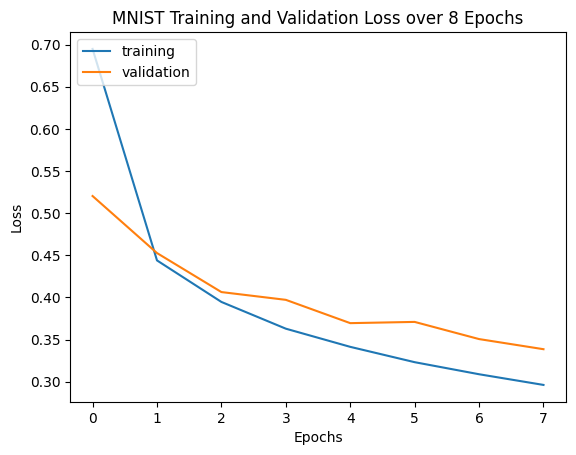

In [ ]:
import matplotlib.pyplot as plot

epochs = range(8)

plt.plot(epochs, training_loss, label = 'training')
plt.plot(epochs, validation_loss, label = 'validation')
plt.legend(loc = 'upper left')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("MNIST Training and Validation Loss over 8 Epochs")
plt.show()

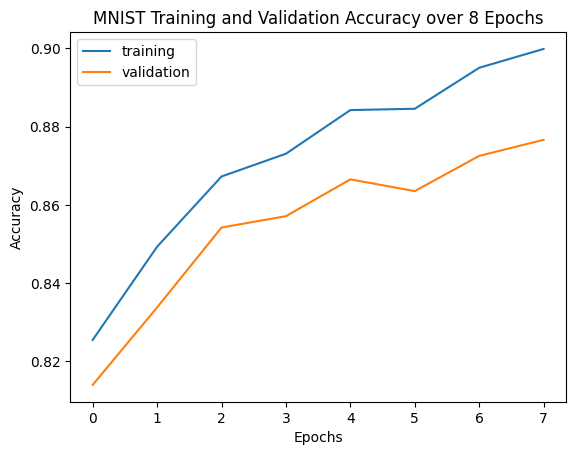

In [ ]:
import matplotlib.pyplot as plot

epochs = range(8)

plt.plot(epochs, training_acc, label = 'training')
plt.plot(epochs, validation_acc, label = 'validation')
plt.legend(loc = 'upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("MNIST Training and Validation Accuracy over 8 Epochs")
plt.show()

# Task 2: CNNs for CIFAR-10

In this section, you will create a CNN for the CIFAR dataset, and submit your predictions to Kaggle. It is recommended that you use GPU acceleration for this part.

Here are some of the components you should consider using:
1. `nn.Conv2d`
2. `nn.ReLU`
3. `nn.Linear`
4. `nn.CrossEntropyLoss`
5. `nn.MaxPooling2d` (though many implementations without it exist)

We encourage you to explore different ways of improving your model to get higher accuracy. Here are some suggestions for things to look into:
1. CNN architectures: AlexNet, VGG, ResNets, etc.
2. Different optimizers and their parameters (see torch.optim)
3. Image preprocessing / data augmentation (see torchvision.transforms)
4. Regularization or dropout (see torch.optim and torch.nn respectively)
5. Learning rate scheduling: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
6. Weight initialization: https://pytorch.org/docs/stable/nn.init.html

Though we encourage you to explore, there are some rules:
1. You are not allowed to install or use packages not included by default in the Colab Environment.
2. You are not allowed to use any pre-defined architectures or feature extractors in your network.
3. You are not allowed to use **any** pretrained weights, ie no transfer learning.
4. You cannot train on the test data.

Otherwise everything is fair game.

Your deliverables are as follows:
1. Submit to Kaggle and include your test accuracy in your report.
2. Provide at least (1) training curve for your model, depicting loss per epoch or step after training for at least 8 epochs.
3. Explain the components of your final model, and how you think your design choices contributed to it's performance.

After you write your code, we have included skeleton code that should be used to submit predictions to Kaggle. **You must follow the instructions below under the submission header**. Note that if you apply any processing or transformations to the data, you will need to do the same to the test data otherwise you will likely achieve very low accuracy. 

It is expected that this task will take a while to train. Our simple solution achieves a training accuracy of 90.2% and a test accuracy of 74.8% after 10 epochs (be careful of overfitting!). This easily beats the best SVM based CIFAR10 model submitted to the HW 1 Kaggle! It is possible to achieve 95% or higher test accuracy on CIFAR 10 with good model design and tuning.

In [4]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p = 0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
# If you make a train-test partition it is up to you.

100%|██████████| 170498071/170498071 [00:03<00:00, 43310100.30it/s]


Extracting data/cifar-10-python.tar.gz to data


In [5]:
### YOUR CODE HERE ###
import tqdm.notebook
import tensorflow
import torch.nn as nn
import torch.nn.functional as func

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

torch.manual_seed(10)

epochs = 30
batch_size = 10
learning_rate = 0.01

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.convolution1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.convolution2 = nn.Conv2d(16, 32, 3, padding = 1)
    self.convolution3 = nn.Conv2d(32, 64, 3, padding = 1)
    self.layer1 = nn.Linear(128 * 8, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256, 10)

  def forward(self, x):
    x = func.relu(self.convolution1(x))
    x = self.pool(x)

    x = func.relu(self.convolution2(x))
    x = self.pool(x)

    x = func.relu(self.convolution3(x))
    x = self.pool(x)

    x = x.view(-1, 128 * 8)

    x = func.relu(self.layer1(x))
    x = func.relu(self.layer2(x))
    x = (self.layer3(x))
    
    return (x)

model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
training_loader = torch.utils.data.DataLoader(training_data, batch_size=10, shuffle=True)

training_loss = []
training_acc = []

model.train() # Put model in training mode
for epoch in range(epochs):
    print("Starting epoch", epoch + 1)

    training_losses = []
    for x, y in tqdm.notebook.tqdm(training_loader, unit="batch"):
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    
    training_loss.append(np.mean(training_losses))
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

    with torch.no_grad():
        model.eval() # Put model in eval mode
        num_correct = 0
        for x, y in training_loader:
            output = model(x)
            tmp, pred = torch.max(output, 1)
            num_correct += np.squeeze(pred.eq(y.data.view_as(pred)))

        training_acc.append(torch.sum(num_correct).item() / len(training_data))
        print("Finished Epoch", epoch + 1, ", training accuracy:", torch.sum(num_correct).item() / len(training_data))
        model.train()


Using device cpu
Starting epoch 1


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 1.9893489856123925
Finished Epoch 1 , training accuracy: 0.41998
Starting epoch 2


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 1.446388912010193
Finished Epoch 2 , training accuracy: 0.53548
Starting epoch 3


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 1.2033759093284606
Finished Epoch 3 , training accuracy: 0.60356
Starting epoch 4


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 1.0319857968837023
Finished Epoch 4 , training accuracy: 0.6771
Starting epoch 5


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.9082990150153637
Finished Epoch 5 , training accuracy: 0.71282
Starting epoch 6


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.8102887218505144
Finished Epoch 6 , training accuracy: 0.74908
Starting epoch 7


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.7303833763636649
Finished Epoch 7 , training accuracy: 0.77152
Starting epoch 8


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.6700378548298032
Finished Epoch 8 , training accuracy: 0.78732
Starting epoch 9


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.6131164625540376
Finished Epoch 9 , training accuracy: 0.79856
Starting epoch 10


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.5669628772430122
Finished Epoch 10 , training accuracy: 0.8309
Starting epoch 11


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 11 , training loss: 0.5237030157893896
Finished Epoch 11 , training accuracy: 0.84244
Starting epoch 12


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 12 , training loss: 0.4806137934828177
Finished Epoch 12 , training accuracy: 0.86132
Starting epoch 13


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 13 , training loss: 0.44187119985362516
Finished Epoch 13 , training accuracy: 0.8612
Starting epoch 14


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 14 , training loss: 0.40922366692731155
Finished Epoch 14 , training accuracy: 0.88532
Starting epoch 15


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 15 , training loss: 0.3706861436084844
Finished Epoch 15 , training accuracy: 0.87426
Starting epoch 16


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 16 , training loss: 0.34312443201374265
Finished Epoch 16 , training accuracy: 0.89992
Starting epoch 17


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 17 , training loss: 0.3094573904701276
Finished Epoch 17 , training accuracy: 0.91042
Starting epoch 18


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 18 , training loss: 0.2843640067190463
Finished Epoch 18 , training accuracy: 0.9106
Starting epoch 19


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 19 , training loss: 0.258339092015248
Finished Epoch 19 , training accuracy: 0.93282
Starting epoch 20


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 20 , training loss: 0.23958972846148535
Finished Epoch 20 , training accuracy: 0.92608
Starting epoch 21


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 21 , training loss: 0.21363842437542627
Finished Epoch 21 , training accuracy: 0.94284
Starting epoch 22


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 22 , training loss: 0.1948389322882169
Finished Epoch 22 , training accuracy: 0.94018
Starting epoch 23


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 23 , training loss: 0.17797950951771346
Finished Epoch 23 , training accuracy: 0.94242
Starting epoch 24


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 24 , training loss: 0.16778150173406975
Finished Epoch 24 , training accuracy: 0.95816
Starting epoch 25


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 25 , training loss: 0.15021981203425674
Finished Epoch 25 , training accuracy: 0.95602
Starting epoch 26


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 26 , training loss: 0.14179339490673645
Finished Epoch 26 , training accuracy: 0.9538
Starting epoch 27


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 27 , training loss: 0.13588477785819414
Finished Epoch 27 , training accuracy: 0.96656
Starting epoch 28


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 28 , training loss: 0.11890778426771394
Finished Epoch 28 , training accuracy: 0.95536
Starting epoch 29


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 29 , training loss: 0.12125079806260255
Finished Epoch 29 , training accuracy: 0.9679
Starting epoch 30


  0%|          | 0/5000 [00:00<?, ?batch/s]

Finished Epoch 30 , training loss: 0.1114799996211832
Finished Epoch 30 , training accuracy: 0.96098


### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar_test_data.npy` to the colab notebook by going to files on the right hand pane, then hitting "upload". 
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [7]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):
    
    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10_test_data_sp23.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10_test_data_sp23.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

transform2 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform2, # NOTE: Make sure transform is the same as used in the training dataset.
)

In [8]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.

# Store a numpy vector of the predictions for the test set in the variable `predictions`.

test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=10, shuffle=False)
predictions = []

with torch.no_grad():
  model.eval() # Put model in eval mode
  
  for x in test_dataloader:
    output = model(x)
    tmp, pred = torch.max(output, 1)

    for el in pred:
      predictions.append(el)

  model.train()

In [12]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1. 
df.to_csv('submission.csv', index_label='Id')

# Now download the submission.csv file to submit.

In [16]:
"""
Kaggle Report

Username: abhinavkommula
Score: 0.75966

Explain the components of your final model, and how you think your design choices contributed to it's performance.

Final Model Components:
The CNN I built for the CIFAR-10 classification problem utilizes 3 convolutional layers, each of which 
has it's data pooled after passing in data through the layers. After passing through the Convolutional
Layers, the data is then passed through 3 separate Linear layers with a ReLU activation function following. 
I decided to start with using 2 convolutional layers and 2 Linear layers, but noticed that this led to lower
training accuracies and inevitably lower test accuracies; I reasoned this was because my model was 
underfitting the data as there were less degrees of freedom available for the model to train on, and as
a result it was unable to capture the majority of the data through the convolutional and linear layers. 
After adding an additional layer, I decided to incorporate a pooling component not only in order to speed 
up the computations but also to address the "curse of dimensionality" error. That is, as the number of 
parameters increases, the amount of training data needed to capture a explainable percentage of the output
increases exponentially. Therefore, I reasoned that by adding this pooling to incorporate a more rich 
summary of the output of each layer that this issue would become mitigated. There were other features
I added to my model in order to help increase testing accuracy such as lowering the learning rate so that 
we do not move too quickly in the direction of the gradient, randomizing not only the order of training data
but also incorporate randomized transoformations like Horizontal Flipping which would occur with probability 
p = 0.5, reshaping the pixel values so that they are within the range [-1, 1] instead of [0, 1] to allow the
model to more visibly identify image features, etc. Finally, I decided to increase the number of epochs for 
training, but I noticed that this led to overfitting as there was a large discrepancy between training accuracy
and testing accuracy. In the future, I believe I could've trained my CNN using less epoch iterations. 
Overall, I believe that these design choices have helped me maximize my testing accuracy.
"""



'\nKaggle Report\n\nUsername: abhinavkommula\nScore: 0.75966\n\nExplain the components of your final model, and how you think your design choices contributed to it\'s performance.\n\nFinal Model Components:\nThe CNN I built for the CIFAR-10 classification problem utilizes 3 convolutional layers, each of which \nhas it\'s data pooled after passing in data through the layers. After passing through the Convolutional\nLayers, the data is then passed through 3 separate Linear layers with a ReLU activation function following. \nI decided to start with using 2 convolutional layers and 2 Linear layers, but noticed that this led to lower\ntraining accuracies and inevitably lower test accuracies; I reasoned this was because my model was \nunderfitting the data as there were less degrees of freedom available for the model to train on, and as\na result it was unable to capture the majority of the data through the convolutional and linear layers. \nAfter adding an additional layer, I decided to inc

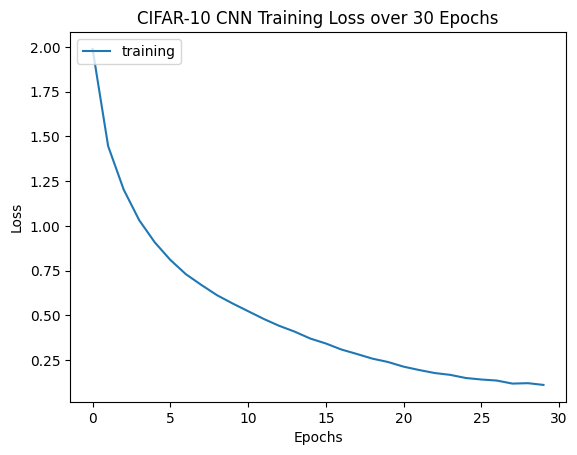

In [18]:
""" Training Loss Curve """

import matplotlib.pyplot as plot

epochs = range(30)

plt.plot(epochs, training_loss, label = 'training')
plt.legend(loc = 'upper left')
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("CIFAR-10 CNN Training Loss over 30 Epochs")
plt.show()


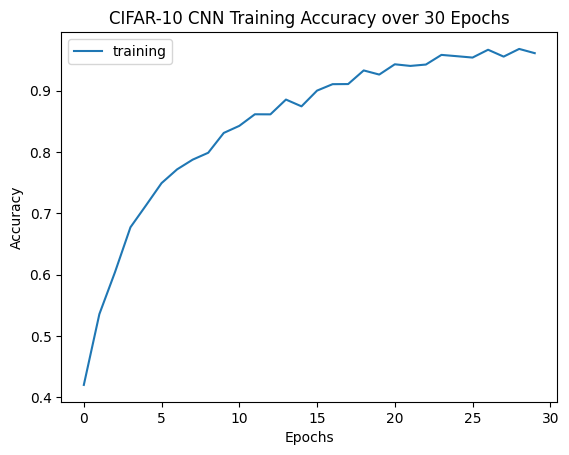

In [20]:
""" Training Accuracy Curve """

import matplotlib.pyplot as plot

epochs = range(30)

plt.plot(epochs, training_acc, label = 'training')
plt.legend(loc = 'upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("CIFAR-10 CNN Training Accuracy over 30 Epochs")
plt.show()


Congrats! You made it to the end.